# Working with output from general circulation models

In this lecture we will discuss some basic aspects and techniques to work with output of general circulation models.

## What is a general circulation model?

A general circulation model (GCM) is a computer model which simulates the circulation a fluid (e.g. the ocean or atmosphere). The model is based on a set of partial differential equations, which describe the motion of a fluid in 3D space, and integrates these forward in time.  Most fundamentally these models use a discrete representation of the [Navier-Stokes Equations](https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations) but can include more equations to represent e.g. the thermodynamics, chemistry or biology of the coupled earth system.

## The globe divided in boxes
Since there is not analytical solution to the full Navier-Stokes equation, modern GCMs solve them using numerical method. They use a discretized version of the equations, which approximates them within a finite volume, or grid-cell. Each GCM splits the ocean and/or atmoshpere into many cells both in the horizontal and vertical.

![gcm-schematic](https://www.ipcc-data.org/img/3d_gcm_structure.jpg)
> Source: www.ipcc-data.org

It is numerically favorable to shift (or 'stagger') the grid points where the velocity is calculated by the model with regard to the grid point where tracer values (temperature, salinity etc.) are calculated. There are several different ways to shift these points, commonly referred to as [Arakawa grids](https://en.wikipedia.org/wiki/Arakawa_grids). Most modern ocean models use a C-Grid, thus this lecture will focus on this particular grid configuration.
In the C-grid, the zonal velocity $u$ is located on the right side (or east face) of the tracer location and the meridional velocity $v$ is located on the upper side (or north face). Similarly the vertical velocity $w$ is shifted with depth but horizontally (when looking at it from straight above) it is on the tracer location.

![c-grid](https://xgcm.readthedocs.io/en/latest/_images/grid2d_hv.svg)
> Source: xgcm.readthedocs.io

## Consequences
Discretizing the equations has consequences: 

- In order to get a realistic representation of the global circulation, the size of grid cells needs to be chosen so that all relevant processes are resolved (often requires too much computing power for global models) or processes that are to small to be explicitly resolved (e.g. [ocean eddies]() or vertical mixing [](), need to be carefully parameterized since they influence the large scale circulation (example?).

- The size of the boxes should not vary too much and cannot be infinitely small, leading to unituitive layout of grid cells particularly around the north pole.

> We will learn how to `regrid` model fields to easier resolutions later in the lesson

- 'squished' boxes (not perfectly rectangular) require careful tracking of the cell geometry (or grid metrics) to calculate operators like e.g. divergence.

> We will learn how to use [xgcm]() in order to deal with computations on the raw model grid.




## Calculus on finite boxes
Sublte differences exists between the numerical methods used in the code of different models, but for this lecture we consider the [Finite Volume Method](https://en.wikipedia.org/wiki/Finite_volume_method), which is used in many modern ocean models. Essentially, this means that all equations with a divergence term are evaluated as fluxes at the surfaces of each finite volume or grid-cell.


## grid size and computation?

## Grid metrics (cells are not actual boxes)

In [1]:
# Video to show difference in resolution
# https://vimeo.com/259423826
from IPython.display import HTML
HTML('<iframe src="https://player.vimeo.com/video/259423826" width="640" height="360" frameborder="0" allow="autoplay; fullscreen" allowfullscreen></iframe>')

/Users/juliusbusecke/miniconda/envs/euc_dynamics/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [2]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xgcm import Grid
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'

In [3]:
import intake
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_model = cat["cesm_mom6_example"].to_dask()

/Users/juliusbusecke/miniconda/envs/euc_dynamics/lib/python3.7/site-packages/xarray/coding/times.py:459: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [4]:
ds_model

<xarray.Dataset>
Dimensions:       (lath: 458, latq: 458, lonh: 540, lonq: 540, nv: 2, scalar_axis: 1, time: 24, xh: 540, xq: 540, yh: 458, yq: 458, z_i: 35, z_l: 34)
Coordinates:
    geolat        (yh, xh) float64 dask.array<chunksize=(458, 540), meta=np.ndarray>
    geolatb       (yq, xq) float64 dask.array<chunksize=(458, 540), meta=np.ndarray>
    geolon        (yh, xh) float64 dask.array<chunksize=(458, 540), meta=np.ndarray>
    geolonb       (yq, xq) float64 dask.array<chunksize=(458, 540), meta=np.ndarray>
  * lath          (lath) float64 -79.2 -79.08 -78.95 ... 87.64 87.71 87.74
  * latq          (latq) float64 -79.14 -79.01 -78.89 ... 87.68 87.73 87.74
  * lonh          (lonh) float64 -286.7 -286.0 -285.3 ... 71.33 72.0 72.67
  * lonq          (lonq) float64 -286.3 -285.7 -285.0 ... 71.67 72.33 73.0
  * nv            (nv) float64 1.0 2.0
  * scalar_axis   (scalar_axis) float64 0.0
  * time          (time) object 0001-01-16 12:00:00 ... 0002-12-16 12:00:00
  * xh            (x

In [5]:
sst_model = ds_model.SST
sst_model

<xarray.DataArray 'SST' (time: 24, yh: 458, xh: 540)>
dask.array<zarr, shape=(24, 458, 540), dtype=float64, chunksize=(1, 458, 540), chunktype=numpy.ndarray>
Coordinates:
    geolat   (yh, xh) float64 dask.array<chunksize=(458, 540), meta=np.ndarray>
    geolon   (yh, xh) float64 dask.array<chunksize=(458, 540), meta=np.ndarray>
  * time     (time) object 0001-01-16 12:00:00 ... 0002-12-16 12:00:00
  * xh       (xh) float64 -286.7 -286.0 -285.3 -284.7 ... 70.67 71.33 72.0 72.67
  * yh       (yh) float64 -79.2 -79.08 -78.95 -78.82 ... 87.55 87.64 87.71 87.74
Attributes:
    cell_measures:  area: area_t
    cell_methods:   area:mean yh:mean xh:mean time: mean
    long_name:      Sea Surface Temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degC

In [6]:
# ds_model[['u', 'v', 'temp']].temp.isel(z_l=0).mean('time').plot()

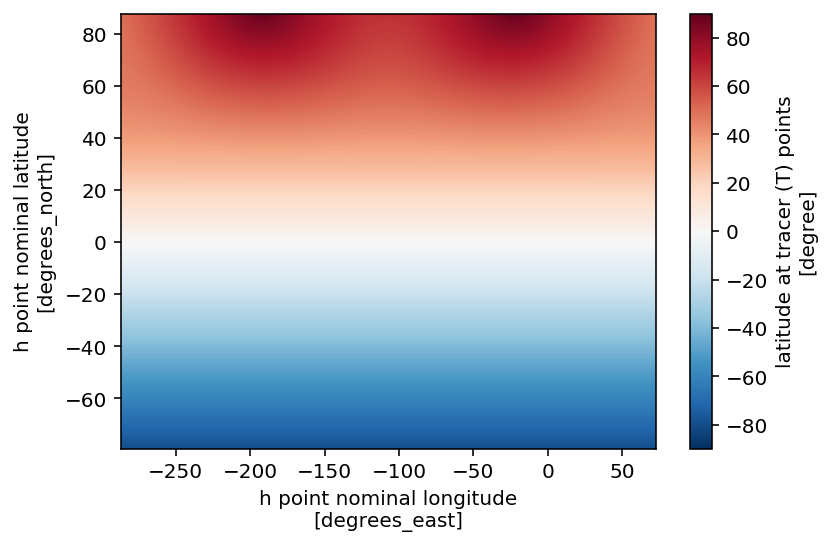

In [7]:
ds_model.geolat.plot()

/Users/juliusbusecke/miniconda/envs/euc_dynamics/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


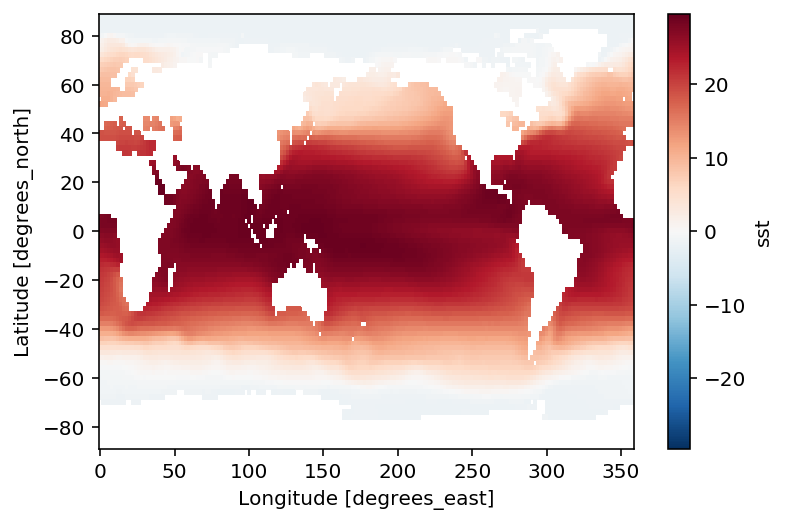

In [8]:
import xarray as xr
# xr.set_options(display_style='html') # !!! need to update xarray for this?
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds_obs = xr.open_dataset(url).chunk({'time': 12})
sst = ds_obs.sst.sel(time=slice('1997', '1998'))#.mean('time').plot()
sst.mean('time').plot()

In [9]:
360/len(ds_model.xh)

0.6666666666666666

In [10]:
360/len(ds_obs.lon)

2.0

Things to note:
    The observational dataset is a lot coarser
    
    The model data is not on a regular lat/lon grid. Values around the pole are distorted
    
So how can we compare them?

1. Upsample the lower resolution data

2. Downsample the higher resolution data

We go with 2 for two seperate reasons: It is not trivial to interpolate with only 

In [11]:
import xesmf as xe

In [12]:
sst_test = sst.chunk({'lon':-1, 'lat':-1, 'time':1})

In [13]:
sst_test

<xarray.DataArray 'sst' (time: 24, lat: 89, lon: 180)>
dask.array<rechunk-merge, shape=(24, 89, 180), dtype=float32, chunksize=(1, 89, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1997-01-01 1997-02-01 ... 1998-12-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]

In [ ]:
# regrid sst observations on 5*5 deg grid

ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 5.0)),
                     'lon': (['lon'], np.arange(0, 360, 5.0)),
                    }
                   )

regridder = xe.Regridder(sst_test, ds_out, 'bilinear')
regridder.clean_weight_file()
regridder

In [12]:
# regrid both data onto even coarser grid

In [13]:
sst.isel(time=0)

<xarray.DataArray 'sst' (lat: 89, lon: 180)>
dask.array<getitem, shape=(89, 180), dtype=float32, chunksize=(89, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
    time     datetime64[ns] 1997-01-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]
    _ChunkSizes:   [  1  89 180]

In [ ]:
# construct a regridder for the model data
sst_model_renamed = sst_model.rename({'geolon':'lon', 'geolat':'lat'})

regridder = xe.Regridder(sst_model_renamed.isel(time=0), sst.isel(time=0), 'bilinear')
regridder.clean_weight_file()
regridder